In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.decomposition import TruncatedSVD

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    roc_curve
)

from tqdm import tqdm

2024-08-21 12:52:44.324843: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 12:52:44.389693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 12:52:46.658405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [4]:
# 처음 5개 칼럼 제외
data = data.drop(data.columns[:5], axis=1)
# 전체가 NaN인 컬럼만 제거
df_train = data.dropna(axis=1, how='all')

In [5]:
df_train

,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE START POSITION X Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,1,OK,240.0,2.5,-90,100,1150,33.5,0,1030,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,1,OK,240.0,2.5,-90,70,1150,33.5,0,1030,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,1,OK,1000.0,12.5,90,85,1150,33.5,0,280,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,1,OK,1000.0,12.5,90,70,1150,33.5,0,280,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,1,OK,240.0,2.5,-90,70,1150,33.5,0,1030,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,1,OK,240.0,2.5,-90,70,1150,33.5,0,1030,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,1,OK,1000.0,12.5,90,100,1150,33.5,0,280,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,1,OK,240.0,2.5,-90,100,1150,33.5,0,1030,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,1,OK,1000.0,12.5,90,70,1150,33.5,0,280,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


In [6]:
string_columns = df_train.select_dtypes(include=['object']).columns

In [7]:
# 0과 1로 표현할 수 있는 칼럼만 남기기
binary_columns = []

for column in string_columns:
    unique_values = df_train[column].dropna().unique()  # NaN 값을 제외한 고유값 계산
    if len(unique_values) >= 2:  # 고유값이 2개 이상인 경우만 선택
        binary_columns.append(column)

# 원본 데이터프레임에서 숫자 칼럼은 그대로 두고, 0과 1로 표현 가능한 문자열 칼럼만 인코딩
df_filtered = df_train.copy()

label_encoders = {}
for column in binary_columns:
    le = LabelEncoder()
    df_filtered.loc[:, column] = le.fit_transform(df_filtered[column])
    label_encoders[column] = le

# 고유값이 1개인 칼럼 제거
columns_to_drop = [col for col in df_filtered.columns if df_filtered[col].nunique() == 1]
df_filtered = df_filtered.drop(columns=columns_to_drop)

In [8]:
df_filtered

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,240.0,2.5,-90,100,1030,-90,16,14.9,8.4,14.7,...,50.0,91.8,270,50,114.612,19.9,7,127,1,1
1,240.0,2.5,-90,70,1030,-90,10,21.3,4.9,21.3,...,91.8,270.0,50,85,19.600,7.0,185,1,0,1
2,1000.0,12.5,90,85,280,90,16,14.7,8.5,14.7,...,50.0,91.8,270,50,114.612,19.8,10,73,1,1
3,1000.0,12.5,90,70,280,90,10,21.3,8.4,21.3,...,91.8,270.0,50,85,19.900,12.0,268,1,0,1
4,240.0,2.5,-90,70,1030,-90,10,9.7,4.9,9.6,...,91.8,270.0,50,85,19.700,8.0,121,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,240.0,2.5,-90,70,1030,-90,10,17.0,5.0,17.0,...,91.8,270.0,50,85,19.200,1.0,318,1,0,1
40502,1000.0,12.5,90,100,280,90,16,14.9,8.5,14.7,...,50.0,91.8,270,50,114.612,20.5,14,197,1,1
40503,240.0,2.5,-90,100,1030,-90,16,14.2,8.2,14.3,...,50.0,91.8,270,50,85.000,19.7,1,27,1,1
40504,1000.0,12.5,90,70,280,90,10,9.7,4.9,9.7,...,91.8,270.0,50,85,20.100,13.0,117,1,0,1


In [10]:
X = df_filtered.drop('target', axis=1).values  # 피처
y = df_filtered['target'].values  # 레이블

In [11]:
# TruncatedSVD를 사용하여 차원 축소
n_components = 50 
svd = TruncatedSVD(n_components=n_components, random_state=42)
train_reduced = svd.fit_transform(X)

In [12]:
train_reduced

array([[ 2.72396042e+04, -5.06899855e+03,  7.89988630e+01, ...,
        -3.00971033e-01, -2.92867640e-01,  7.72921973e-01],
       [ 2.83521009e+04,  7.20295302e+03,  7.24292801e+03, ...,
        -3.08138859e-01,  2.47687720e-01,  1.27171895e-01],
       [ 2.74282152e+04, -5.53441817e+03,  7.03040454e+02, ...,
        -4.34381318e-01,  5.10187063e-01,  1.38315997e+00],
       ...,
       [ 2.82370073e+04, -5.20573943e+03,  4.80529283e+01, ...,
        -1.41690562e-01,  1.98531591e-01, -4.82480943e-01],
       [ 4.38484279e+04,  3.67584152e+03, -4.36871732e+03, ...,
        -1.40087914e-01,  1.06967480e-01, -1.10805043e-01],
       [ 4.89833016e+04,  7.33531734e+03,  5.09157713e+02, ...,
         2.57375328e-01, -3.27631559e-01,  7.85391262e-02]])

In [13]:
# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_reduced)

In [14]:
X_scaled

array([[-0.62919045, -0.79479144, -0.09285534, ..., -0.3199931 ,
        -0.3275179 ,  1.01819689],
       [-0.49613876,  1.51560156,  2.3382396 , ..., -0.32761512,
         0.27668873,  0.16748968],
       [-0.60663308, -0.88241419,  0.11891453, ..., -0.46185696,
         0.5700978 ,  1.82212071],
       ...,
       [-0.50990365, -0.82053511, -0.10335691, ..., -0.15061979,
         0.22174439, -0.63566326],
       [ 1.35718134,  0.85156588, -1.60219751, ..., -0.14891559,
         0.11939846, -0.14601969],
       [ 1.97129878,  1.54052128,  0.05312   , ...,  0.27373298,
        -0.36637533,  0.10342116]])

In [15]:
# 훈련과 테스트 데이터 분리 (테스트 데이터에는 정상과 비정상 모두 포함)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
# 훈련 데이터에서 정상 데이터만 필터링
X_train_normal = X_train[y_train == 1]

In [23]:
def create_sequences_by_column(data, timesteps):
    sequences = []
    for row in data:
        row_sequences = []
        for i in range(len(row) - timesteps + 1):
            row_sequences.append(row[i:i + timesteps])
        sequences.append(row_sequences)
    return np.array(sequences)

timesteps = 10  # 시계열의 길이 설정

X_train_data = create_sequences_by_column(X_train_normal, timesteps)
X_test_data = create_sequences_by_column(X_test, timesteps)

In [24]:
# 모델의 입력 형상을 데이터에 맞게 수정
features = X_train_data.shape[2]
timesteps = X_train_data.shape[1]  # 133으로 변경

model = Sequential([
    LSTM(32, activation='relu', input_shape=(timesteps, features), return_sequences=True, kernel_initializer='glorot_uniform'),
    BatchNormalization(),
    Dropout(0.2),  # 20%의 뉴런 비활성화
    LSTM(16, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=True),
    TimeDistributed(Dense(features))
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='huber')


In [25]:
# 모델 학습
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_data, X_train_data, epochs=50, batch_size=64, validation_split=0.2, shuffle=False, callbacks=[early_stopping])

Epoch 1/50
382/382 [==============================] - 20s 41ms/step - loss: 0.2326 - val_loss: 0.2270
Epoch 2/50
382/382 [==============================] - 16s 43ms/step - loss: 0.2278 - val_loss: 0.2262
Epoch 3/50
382/382 [==============================] - 24s 62ms/step - loss: 0.2269 - val_loss: 0.2338
Epoch 4/50
382/382 [==============================] - 24s 62ms/step - loss: 0.2261 - val_loss: 0.2243
Epoch 5/50
382/382 [==============================] - 23s 61ms/step - loss: 0.2242 - val_loss: 0.2215
Epoch 6/50
382/382 [==============================] - 23s 61ms/step - loss: 0.2211 - val_loss: 0.2173
Epoch 7/50
382/382 [==============================] - 23s 60ms/step - loss: 0.2182 - val_loss: 0.2139
Epoch 8/50
382/382 [==============================] - 23s 60ms/step - loss: 0.2160 - val_loss: 0.2116
Epoch 9/50
382/382 [==============================] - 23s 60ms/step - loss: 0.2138 - val_loss: 0.2090
Epoch 10/50
382/382 [==============================] - 23s 60ms/step - loss: 0.210

In [26]:
# 테스트 데이터 예측 및 재구성 오차 계산
test_encoded = model.predict(X_test_data)
reconstruction_error = np.mean(np.abs(X_test_data - test_encoded), axis=(1, 2))

254/254 [==============================] - 4s 12ms/step


In [27]:
# y_test를 int 타입으로 변환
y_test = np.array(y_test, dtype=int)

In [86]:
# # reconstruction_error가 1차원 배열인지 확인
# if reconstruction_error.ndim > 1:
#     reconstruction_error = reconstruction_error.flatten()

threshold = np.percentile(reconstruction_error, 80)
anomalies = reconstruction_error > threshold

In [87]:
labels = np.where(anomalies, 'AbNormal', 'Normal')

# 결과 출력
print(labels)

['Normal' 'Normal' 'Normal' ... 'Normal' 'Normal' 'Normal']


In [88]:
len(labels)

8102

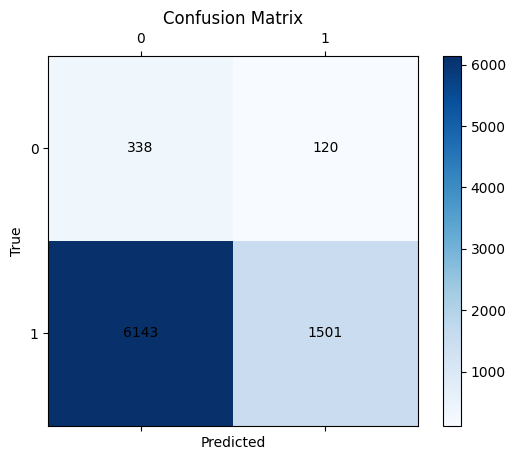

In [89]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, anomalies)

# 혼동행렬 시각화
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f'{val}', ha='center', va='center')

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

In [90]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [91]:
test_data

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,0001be084fbc4aaa9d921f39e595961b,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3J1XF767-1,1,OK,1000.0,NaN,...,195,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
1,0005bbd180064abd99e63f9ed3e1ac80,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4B1XD472-2,1,OK,1000.0,NaN,...,14,NaN,NaN,256,NaN,NaN,1,NaN,NaN,NaN
2,000948934c4140d883d670adcb609584,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3H1XE355-1,1,OK,240.0,NaN,...,98,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
3,000a6bfd02874c6296dc7b2e9c5678a7,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3L1XA128-1,1,OK,1000.0,NaN,...,14,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN
4,0018e78ce91343678716e2ea27a51c95,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4A1XA639-1,1,OK,240.0,NaN,...,1,NaN,NaN,215,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1XB597-1,1,OK,1000.0,NaN,...,14,NaN,NaN,131,NaN,NaN,1,NaN,NaN,NaN
17357,ffed8923c8a448a98afc641b770be153,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4A1XB974-1,1,OK,1000.0,NaN,...,12,NaN,NaN,279,NaN,NaN,1,NaN,NaN,NaN
17358,fff1e73734da40adbe805359b3efb462,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3L1XA998-1,1,OK,240.0,NaN,...,4,NaN,NaN,66,NaN,NaN,1,NaN,NaN,NaN
17359,fff8e38bdd09470baf95f71e92075dec,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1XC376-1,1,OK,240.0,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN


In [92]:
df_test_filtered = test_data.copy()

df_test_filtered = df_test_filtered[df_filtered.columns.intersection(df_test_filtered.columns)]

# 동일한 인코딩 적용
for column, le in label_encoders.items():
    if column in df_test_filtered.columns:
        # 테스트 데이터셋에 동일한 LabelEncoder 적용
        df_test_filtered[column] = df_test_filtered[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

In [93]:
df_test_filtered

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,1000.0,12.5,90,70,280,90,10,17.0,4.9,17.0,...,91.8,270.0,50,85,19.8,13.0,195,1,0,-1
1,1000.0,12.5,90,70,280,90,16,14.2,8.3,14.2,...,50.0,91.8,270,50,85.0,19.8,14,256,1,-1
2,240.0,2.5,-90,70,1030,-90,10,9.7,4.9,9.7,...,91.8,270.0,50,85,19.7,1.0,98,1,0,-1
3,1000.0,12.5,90,70,280,90,10,21.3,10.6,21.3,...,50.0,91.8,270,50,85.0,20.0,14,0,1,-1
4,240.0,2.5,-90,70,1030,-90,16,13.2,7.5,13.2,...,50.0,91.8,270,50,85.0,19.8,1,215,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,1000.0,12.5,90,70,280,90,10,21.3,10.6,21.3,...,50.0,91.8,270,50,85.0,19.5,14,131,1,-1
17357,1000.0,12.5,90,70,280,90,16,13.2,7.6,13.2,...,50.0,91.8,270,50,85.0,19.8,12,279,1,-1
17358,240.0,2.5,-90,70,1030,-90,16,13.2,6.6,13.2,...,50.0,91.8,270,50,85.0,20.5,4,66,1,-1
17359,240.0,2.5,-90,70,1030,-90,10,9.7,3.9,9.7,...,91.8,270.0,50,85,18.9,1.0,117,1,0,-1


In [94]:
X_test_data = df_test_filtered.drop('target', axis=1).values 
test_reduced = svd.fit_transform(X_test_data)
X_test_data_scaled = scaler.fit_transform(test_reduced)
X_test_data_sequence = create_sequences_by_column(X_test_data_scaled, timesteps)

In [97]:
X_test_data_sequence.shape

(17361, 10, 41)

In [99]:
# 축을 변경하여 (batch_size, timesteps, features) 형식으로 변환
X_test_data_sequence = np.transpose(X_test_data_sequence, (0, 2, 1))

# 이제 새로운 shape를 확인
print(X_test_data_sequence.shape)

(17361, 41, 10)


In [112]:
# 테스트 데이터 예측 및 이상치 탐지
test_encoded = model.predict(X_test_data_sequence)
# 재구성 오차 계산: 각 시퀀스에 대해 하나의 값만 남도록 축 조정
reconstruction_error = np.mean(np.abs(X_test_data_sequence - test_encoded), axis=(1, 2))

threshold = np.percentile(reconstruction_error, 80)
anomalies = reconstruction_error > threshold

543/543 [==============================] - 7s 12ms/step


In [113]:
# Normal과 Abnormal 문자열로 반환
labels = np.where(anomalies, 'AbNormal', 'Normal')
labels = labels.astype(object)
labels

array(['Normal', 'Normal', 'AbNormal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [114]:
test_pred_series = pd.Series(labels)
count_labels = test_pred_series.value_counts()

print(count_labels)

Normal      13889
AbNormal     3472
Name: count, dtype: int64


In [115]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = labels

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)